# EX4 주식 예측에 도전해 보자

# 1. Boeing

## 1. 시계열 데이터 준비

In [55]:
import pandas
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath_1 = '/content/drive/MyDrive/aiffel/stock_prediction/data/BA.csv'
df_1 = pd.read_csv(dataset_filepath_1, index_col='Date', parse_dates=True)
ts_1 = df_1['Close']

ts_1.head()

# 필요한 라이브러리들을 불러온다

Date
2021-07-26    225.850006
2021-07-27    222.270004
2021-07-28    231.570007
2021-07-29    231.630005
2021-07-30    226.479996
Name: Close, dtype: float64

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. 각종 전처리 수행

- 널값 제거
- 로그 변환

In [57]:
ts_1 = ts_1.interpolate(method='time')
ts_1[ts_1.isna()]
# 추후 생길 오류를 막기위해 null값들을 제거해준다

ts_log_1 = np.log(ts_1)

# 시간추이에 따라 분산이 커질때 로그값을 취하면 안정적이게 된다

## 3. 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해
- Residual 안정성 확인

In [58]:
#!pip install statsmodels==0.12.1

###3-1 함수 선언

In [59]:
# 구간 통계치를 시각화 하는 함수
# 현재 타임스텝부터 window에 주어진 타임 스탭이전사이의
# 구간의 평균과 표준편차를 원본시계열과 함께 시각화 한다

def plot_rolling_statistics(timeseries, window = 12):

  rolmean = timeseries.rolling(window = window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window = window).std()    # 이동표준편차 시계열
# 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  orig = plt.plot(timeseries, color='blue', label = 'Original')
  mean = plt.plot(rolmean, color ='red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color ='black', label='Rolling Std')
  plt.legend(loc ='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block = False)

In [60]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

  print(dfoutput)

### 3-2 그래프 분석

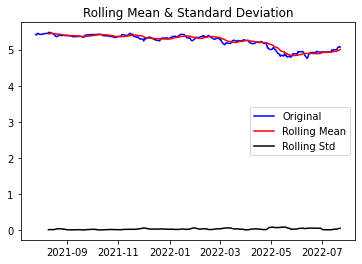

Results of Dickey-Fuller Test:
Test Statistic                 -1.381209
p-value                         0.591251
#Lags Used                      2.000000
Number of Observation Used    248.000000
Critical Value (1%)            -3.456996
Critical Value (5%)            -2.873266
Critical Value (10%)           -2.573019
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':


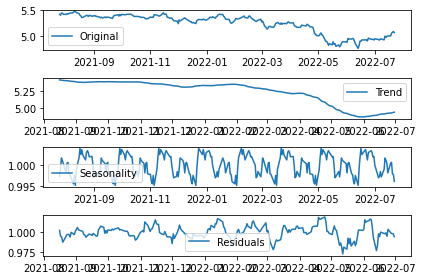

In [61]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_1, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_1)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_1 = seasonal_decompose(ts_log_1, model='multiplicative', freq = 30) 

trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
residual_1 = decomposition_1.resid

plt.subplot(411)
plt.plot(ts_log_1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_1, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_1,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_1, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 오리지날 그래프, Trend그래프, Seasonary그래프, 그리고 trend와 seasonary를 뺀
# Residual 그래프를 순서대로 시각화한다 

In [62]:
# Residual 안정성 확인
residual_1.dropna(inplace=True)
augmented_dickey_fuller_test(residual_1)

# p-value가 매우 낮기 때문에 그래프는 안정적이다

Results of Dickey-Fuller Test:
Test Statistic               -5.758137e+00
p-value                       5.755481e-07
#Lags Used                    2.000000e+00
Number of Observation Used    2.180000e+02
Critical Value (1%)          -3.460708e+00
Critical Value (5%)          -2.874891e+00
Critical Value (10%)         -2.573886e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

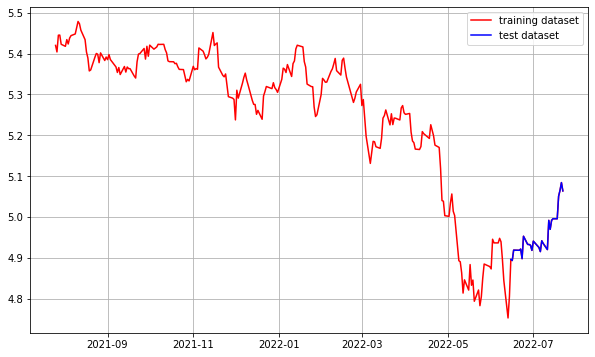

In [63]:
train_data, test_data = ts_log_1[:int(len(ts_log_1)*0.9)], ts_log_1[int(len(ts_log_1)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_1, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 학습, 테스트 데이터 셋을 분리해준다

## 5. 적정 ARIMA모수 찾기

- ACF, PACF 그려보고 p, q를 구하고
- 차분 안정성을 확인 해 d를 구한다

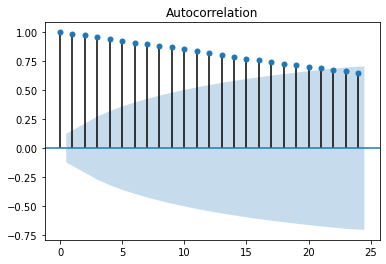

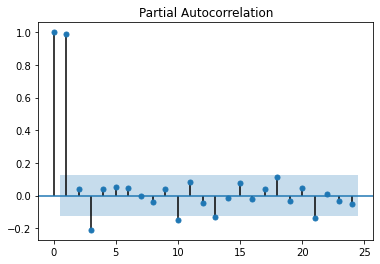

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_1)  
plot_pacf(ts_log_1)  
plt.show()


Results of Dickey-Fuller Test:
Test Statistic               -9.761703e+00
p-value                       7.532990e-17
#Lags Used                    1.000000e+00
Number of Observation Used    2.480000e+02
Critical Value (1%)          -3.456996e+00
Critical Value (5%)          -2.873266e+00
Critical Value (10%)         -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic               -8.648721e+00
p-value                       5.185025e-14
#Lags Used                    1.000000e+01
Number of Observation Used    2.380000e+02
Critical Value (1%)          -3.458128e+00
Critical Value (5%)          -2.873762e+00
Critical Value (10%)         -2.573283e+00
dtype: float64


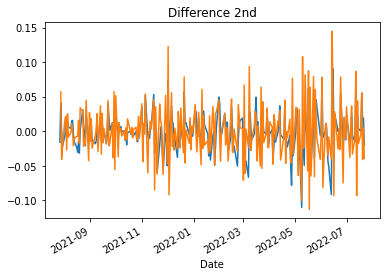

In [65]:
diff_1 = ts_log_1.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)


## 6. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [66]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(20, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(20, 0, 1)   Log Likelihood                 496.107
Date:                Fri, 29 Jul 2022   AIC                           -946.214
Time:                        08:28:13   BIC                           -867.643
Sample:                             0   HQIC                          -914.502
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1167      0.225     22.728      0.000       4.675       5.558
ar.L1          0.1759      0.992      0.177      0.859      -1.767       2.119
ar.L2          1.0123      1.001      1.011      0.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


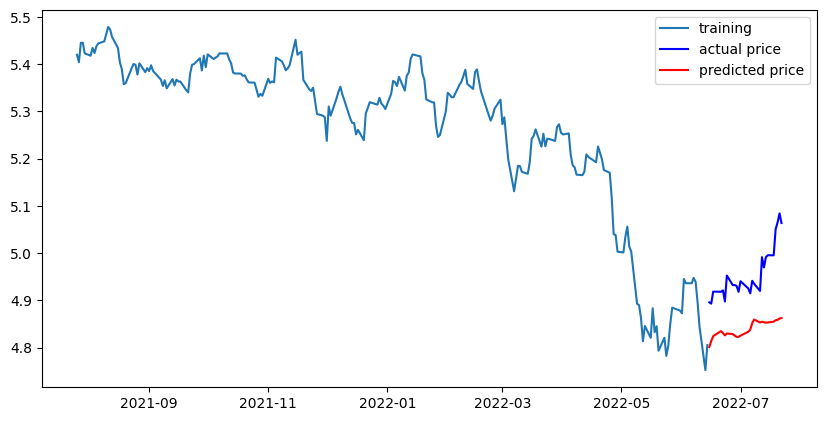

In [67]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series_1 = pd.Series(fc, index=test_data.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()


In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse_1 = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse_1)

mae_1 = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae_1)

rmse_1 = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse_1)

mape_1 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape_1*100))

MSE:  298.4367092365271
MAE:  15.992310569347707
RMSE:  17.275320814286694
MAPE: 11.02%


# 2. Microsoft

## 1. 시계열 데이터 준비

In [69]:
import pandas
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath_2 = '/content/drive/MyDrive/aiffel/stock_prediction/data/MSFT.csv'
df_2 = pd.read_csv(dataset_filepath_1, index_col='Date', parse_dates=True)
ts_2 = df_2['Close']
# 종가만 가져오겠다

ts_1.head()


Date
2021-07-26    225.850006
2021-07-27    222.270004
2021-07-28    231.570007
2021-07-29    231.630005
2021-07-30    226.479996
Name: Close, dtype: float64

## 2. 각종 전처리 수행

- 널값 제거
- 로그 변환

In [70]:
ts_2 = ts_2.interpolate(method='time')
ts_2[ts_2.isna()]
# 추후 생길 오류를 막기위해 null값들을 제거해준다

ts_log_2 = np.log(ts_2)

# 시간추이에 따라 분산이 커질때 로그값을 취하면 안정적이게 된다

## 3. 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해
- Residual 안정성 확인

###3-1 함수 선언

In [71]:
# 구간 통계치를 시각화 하는 함수
# 현재 타임스텝부터 window에 주어진 타임 스탭이전사이의
# 구간의 평균과 표준편차를 원본시계열과 함께 시각화 한다

def plot_rolling_statistics(timeseries, window = 12):

  rolmean = timeseries.rolling(window = window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window = window).std()    # 이동표준편차 시계열
# 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  orig = plt.plot(timeseries, color='blue', label = 'Original')
  mean = plt.plot(rolmean, color ='red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color ='black', label='Rolling Std')
  plt.legend(loc ='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block = False)

In [72]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

  print(dfoutput)

### 3-2 그래프 분석

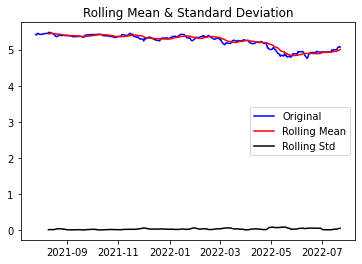

Results of Dickey-Fuller Test:
Test Statistic                 -1.381209
p-value                         0.591251
#Lags Used                      2.000000
Number of Observation Used    248.000000
Critical Value (1%)            -3.456996
Critical Value (5%)            -2.873266
Critical Value (10%)           -2.573019
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':


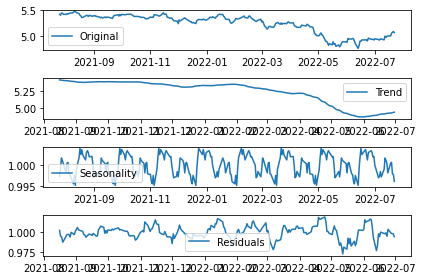

In [73]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_2, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_2)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_2 = seasonal_decompose(ts_log_2, model='multiplicative', freq = 30) 

trend_2 = decomposition_1.trend
seasonal_2 = decomposition_2.seasonal
residual_2 = decomposition_2.resid

plt.subplot(411)
plt.plot(ts_log_2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 오리지날 그래프, Trend그래프, Seasonary그래프, 그리고 trend와 seasonary를 뺀
# Residual 그래프를 순서대로 시각화한다 

In [74]:
# Residual 안정성 확인
residual_2.dropna(inplace=True)
augmented_dickey_fuller_test(residual_2)

# p-value가 매우 낮기 때문에 그래프는 안정적이다

Results of Dickey-Fuller Test:
Test Statistic               -5.758137e+00
p-value                       5.755481e-07
#Lags Used                    2.000000e+00
Number of Observation Used    2.180000e+02
Critical Value (1%)          -3.460708e+00
Critical Value (5%)          -2.874891e+00
Critical Value (10%)         -2.573886e+00
dtype: float64


4. 학습, 테스트 데이터셋 생성

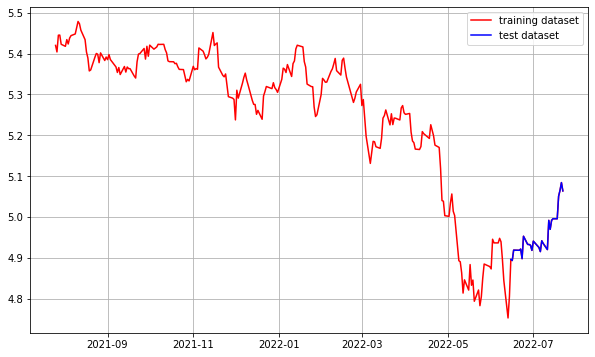

In [75]:
train_data, test_data = ts_log_2[:int(len(ts_log_2)*0.9)], ts_log_2[int(len(ts_log_2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA모수 찾기
- ACF, PACF 그려보고 p, q를 구하고
- 차분 안정성을 확인 해 d를 구한다

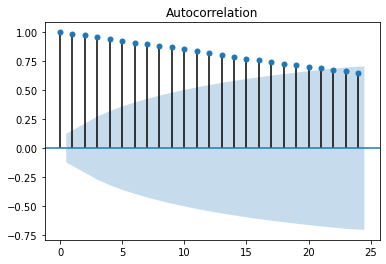

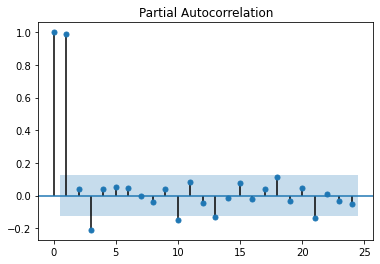

In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_2)  
plot_pacf(ts_log_2)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic               -9.761703e+00
p-value                       7.532990e-17
#Lags Used                    1.000000e+00
Number of Observation Used    2.480000e+02
Critical Value (1%)          -3.456996e+00
Critical Value (5%)          -2.873266e+00
Critical Value (10%)         -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic               -8.648721e+00
p-value                       5.185025e-14
#Lags Used                    1.000000e+01
Number of Observation Used    2.380000e+02
Critical Value (1%)          -3.458128e+00
Critical Value (5%)          -2.873762e+00
Critical Value (10%)         -2.573283e+00
dtype: float64


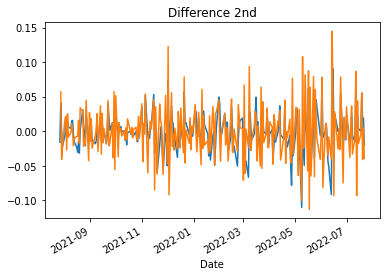

In [77]:
diff_3 = ts_log_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_3)

diff_4 = diff_1.diff(periods=1).iloc[1:]
diff_4.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_4)


## 6. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [78]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(22, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(22, 0, 1)   Log Likelihood                 496.059
Date:                Fri, 29 Jul 2022   AIC                           -942.119
Time:                        08:28:25   BIC                           -856.716
Sample:                             0   HQIC                          -907.650
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1959      0.168     30.860      0.000       4.866       5.526
ar.L1          0.2045      2.205      0.093      0.926      -4.118       4.527
ar.L2          0.9950      2.216      0.449      0.6

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


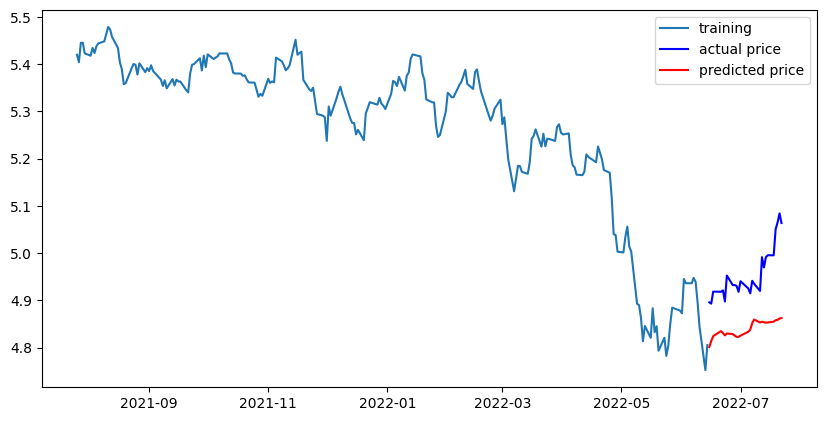

In [79]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series_2 = pd.Series(fc, index=test_data.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse_1 = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse_1)

mae_1 = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae_1)

rmse_1 = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse_1)

mape_1 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape_1*100))

MSE:  228.0362867311983
MAE:  13.997254143663563
RMSE:  15.100870396477095
MAPE: 9.66%


# 3. apple

## 1. 시계열 데이터 준비

In [81]:
import pandas
import sklearn
import statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath_1 = '/content/drive/MyDrive/aiffel/stock_prediction/data/BA.csv'
df_1 = pd.read_csv(dataset_filepath_1, index_col='Date', parse_dates=True)
ts_1 = df_1['Close']

ts_1.head()

Date
2021-07-26    225.850006
2021-07-27    222.270004
2021-07-28    231.570007
2021-07-29    231.630005
2021-07-30    226.479996
Name: Close, dtype: float64

## 2. 각종 전처리 수행

- 널값 제거
- 로그 변환

In [82]:
ts_1 = ts_1.interpolate(method='time')
ts_1[ts_1.isna()]
# 추후 생길 오류를 막기위해 null값들을 제거해준다

ts_log_1 = np.log(ts_1)

# 시간추이에 따라 분산이 커질때 로그값을 취하면 안정적이게 된다

## 3. 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해
- Residual 안정성 확인

In [83]:
# 구간 통계치를 시각화 하는 함수
# 현재 타임스텝부터 window에 주어진 타임 스탭이전사이의
# 구간의 평균과 표준편차를 원본시계열과 함께 시각화 한다

def plot_rolling_statistics(timeseries, window = 12):

  rolmean = timeseries.rolling(window = window).mean()  # 이동평균 시계열
  rolstd = timeseries.rolling(window = window).std()    # 이동표준편차 시계열
# 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
  orig = plt.plot(timeseries, color='blue', label = 'Original')
  mean = plt.plot(rolmean, color ='red', label = 'Rolling Mean')
  std = plt.plot(rolstd, color ='black', label='Rolling Std')
  plt.legend(loc ='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block = False)

In [84]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  dftest = adfuller(timeseries, autolag='AIC')

  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observation Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value

  print(dfoutput)

### 3-2 그래프 분석

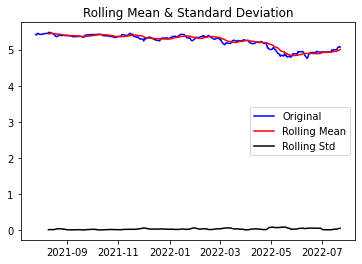

Results of Dickey-Fuller Test:
Test Statistic                 -1.381209
p-value                         0.591251
#Lags Used                      2.000000
Number of Observation Used    248.000000
Critical Value (1%)            -3.456996
Critical Value (5%)            -2.873266
Critical Value (10%)           -2.573019
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':


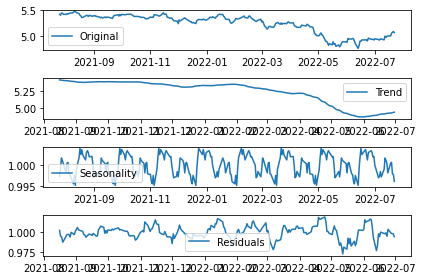

In [85]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log_1, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_1)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_1 = seasonal_decompose(ts_log_1, model='multiplicative', freq = 30) 

trend_1 = decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
residual_1 = decomposition_1.resid

plt.subplot(411)
plt.plot(ts_log_1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_1, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_1,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_1, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 오리지날 그래프, Trend그래프, Seasonary그래프, 그리고 trend와 seasonary를 뺀
# Residual 그래프를 순서대로 시각화한다 

In [86]:
# Residual 안정성 확인
residual_1.dropna(inplace=True)
augmented_dickey_fuller_test(residual_1)

# p-value가 매우 낮기 때문에 그래프는 안정적이다

Results of Dickey-Fuller Test:
Test Statistic               -5.758137e+00
p-value                       5.755481e-07
#Lags Used                    2.000000e+00
Number of Observation Used    2.180000e+02
Critical Value (1%)          -3.460708e+00
Critical Value (5%)          -2.874891e+00
Critical Value (10%)         -2.573886e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

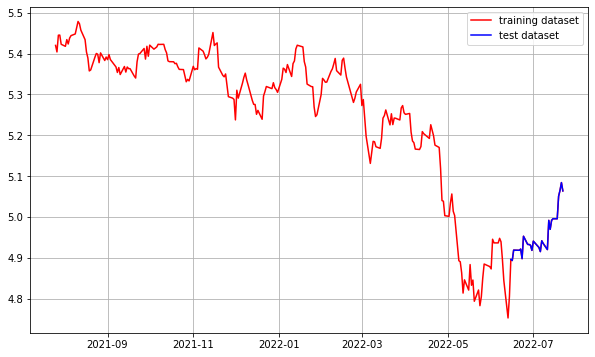

In [87]:
train_data, test_data = ts_log_1[:int(len(ts_log_1)*0.9)], ts_log_1[int(len(ts_log_1)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log_1, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA모수 찾기

- ACF, PACF 그려보고 p, q를 구하고
- 차분 안정성을 확인 해 d를 구한다

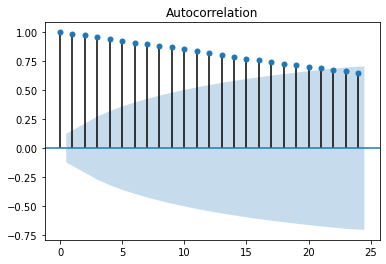

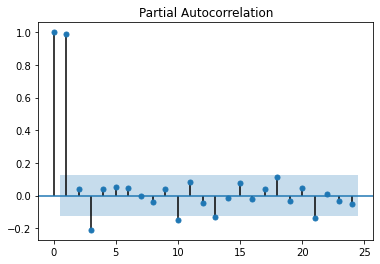

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log_1)  
plot_pacf(ts_log_1)  
plt.show()

Results of Dickey-Fuller Test:
Test Statistic               -9.761703e+00
p-value                       7.532990e-17
#Lags Used                    1.000000e+00
Number of Observation Used    2.480000e+02
Critical Value (1%)          -3.456996e+00
Critical Value (5%)          -2.873266e+00
Critical Value (10%)         -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic               -8.648721e+00
p-value                       5.185025e-14
#Lags Used                    1.000000e+01
Number of Observation Used    2.380000e+02
Critical Value (1%)          -3.458128e+00
Critical Value (5%)          -2.873762e+00
Critical Value (10%)         -2.573283e+00
dtype: float64


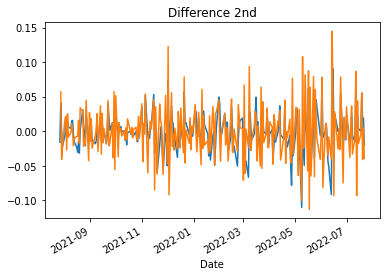

In [89]:
diff_1 = ts_log_1.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 6. ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [90]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(22, 0, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(22, 0, 2)   Log Likelihood                 497.576
Date:                Fri, 29 Jul 2022   AIC                           -943.153
Time:                        08:28:37   BIC                           -854.334
Sample:                             0   HQIC                          -907.305
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1744      0.224     23.147      0.000       4.736       5.613
ar.L1         -0.1846      0.456     -0.405      0.685      -1.078       0.709
ar.L2          0.6694      0.444      1.508      0.1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


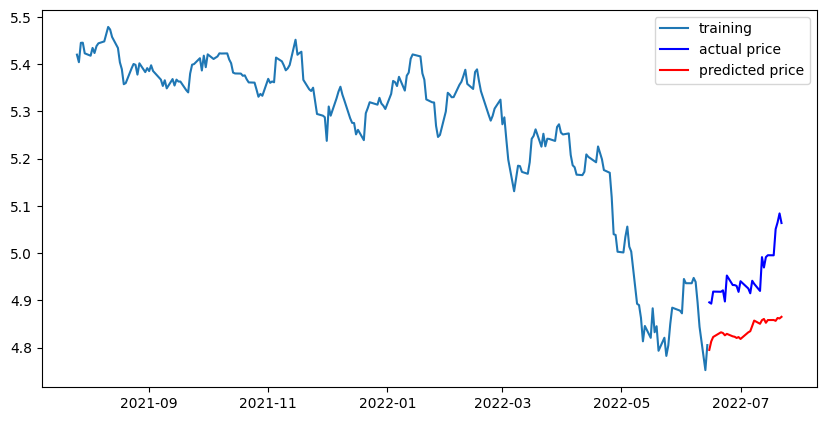

In [91]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series_1 = pd.Series(fc, index=test_data.index)   # 예측결과

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series_1, c='r',label='predicted price')
plt.legend()
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse_1 = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse_1)

mae_1 = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae_1)

rmse_1 = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse_1)

mape_1 = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape_1*100))

MSE:  299.1411534458633
MAE:  16.089419120836222
RMSE:  17.29569754146572
MAPE: 11.10%


# 4. 회고

이번장은 정말 시작부터 너무 어려웠다 전체 익스플로레이션을 이해할때부터 어려움을 겪었고 시계열 그래프와 그것을 안정화 하는 log, trend, season 그래프를 제거하여 안정화 시키는 부분을 배우고 arima모델을 설계하는 부분에서 arima에 대한 이론까진 이해를 하였으나 p와 q값을 설계하는 부분을 이해하지 못했다 주식에 관심이 있어서 이번장에서 잘 배워보고 싶었으나 너무 어려워서 아쉬움이 크다.